# Table of contents
* [Word Tokenization](#word-tokenization)
    * [Most Common Words](#most-common-words)
    * [Feature Creation](#most-common-words-feature-creation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Import the tweets dataset, this is a cut down version of the full tweet 
# dataset per the operations performed in the file "eda-rea-v-liv-2018"
en_tweets_df = pd.read_csv('en_tweets_df.csv', lineterminator='\n')

In [3]:
# As this dataset is generated from earlier work it carries its prior index, the below changes the column name
en_tweets_df.rename(columns={'Unnamed: 0':'original_df_index'}, inplace=True)

In [4]:
# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn import preprocessing

import re

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Word Tokenization <a class="anchor" id="word-tokenization"></a>

In [5]:
# Create a function that returns tokenizes, cleans and stems words for a tweet
english_stopwords = stopwords.words('english')

# Context specific stop words (refer "most common words" section below for identification approach
# rt = short for retweet, this does not provide any insights and a column already exists to identify retweets
# http & https = the start of web links these provide little value as "words", future work: these could be
# to build a feature along thelines of "Contains Web Link?"
# uclfinal, championsleague, championsleaguefinal = "hashtag"/topical words, given the original tweet dataset
# contained only tweets that had a hashtag of uclfinal these words do not add value to the analysis
custom_stopwords = ['rt', 'http', 'https', 'uclfinal', 'championsleague', 'championsleaguefinal', 'lfcrma',  
                    'liverpoolvsrealmadrid', 'livrma', 'realiv', 'realliverpool', 'realmadridliverpool', 'realmadridvsliverpool', 
                    'rmalfc', 'rmaliv', 'rmavlfc', 'rmavliv', 'rmavsliv', 'rmliv', 'rmvsliv']

ps = PorterStemmer()

# Combine the two stop words lists
stop_words = english_stopwords + custom_stopwords

def TokenizeTweet(tweet):
    word_tokenized = word_tokenize(tweet)

    
    cleaned_words_tokenized = [word.lower().strip() for word in word_tokenized] # lowercasing
    
    cleaned_words_tokenized = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', word) for word in cleaned_words_tokenized] # remove URLs
    cleaned_words_tokenized = [re.sub('@[^\s]+', 'AT_USER', word) for word in cleaned_words_tokenized] # remove usernames
    cleaned_words_tokenized = [re.sub(r'#([^\s]+)', r'\1', word) for word in cleaned_words_tokenized] # remove the # in #hashtag   
    cleaned_words_tokenized = [word.replace('(','').replace(')','') for word in cleaned_words_tokenized if word.isalpha()]  # replacing some unwanted things
    
    # Ideally all checks could be moved into this single for loop, rather than iterating words multiple times.
    for n, i in enumerate(cleaned_words_tokenized):
        if i in ['liverpool', 'lfc', 'ufcliverpool', 'liv']:
            cleaned_words_tokenized[n] = 'liverpoolfc'
            
        if i in ['rma', 'madrid']:
            cleaned_words_tokenized[n] = 'realmadrid'
    
    cleaned_words_tokenized = [word for word in cleaned_words_tokenized if word not in stop_words] # removing stopwords
    cleaned_words_tokenized = [ps.stem(word) for word in cleaned_words_tokenized] # stemming
    
    return cleaned_words_tokenized

In [6]:
# Tokenize words in tweets
en_tweets_df['tokenized_words'] = en_tweets_df.apply(lambda row: TokenizeTweet(row['tweet_text']), axis=1)

### Most Common Words <a class="anchor" id="most-common-words"></a>

In [7]:
# There are three key benefits to finding the most common words:
    # 1. Further refinements could be made to TokenizedWords in terms of words to exclude
    # 2. We can obtain further insights into the data
    # 3. Can select key words that could be used to generate features    

# Convert tokenized words column into a single list of words, ignoring retweets to get a true view on most frequently
# tweeted words
words_list = en_tweets_df['tokenized_words'][en_tweets_df['is_retweet']==False].values.tolist()

# Flatten the list
flattened_words_list = [j for sub in words_list for j in sub]

# Find the most common words
fdist = FreqDist(x.lower() for x in flattened_words_list)
fdist.most_common(250)

[('liverpoolfc', 17625),
 ('realmadrid', 10342),
 ('ramo', 7507),
 ('salah', 7506),
 ('bale', 5764),
 ('real', 5611),
 ('goal', 5504),
 ('game', 3903),
 ('kariu', 3770),
 ('final', 2797),
 ('go', 2743),
 ('halamadrid', 2707),
 ('win', 2690),
 ('like', 2629),
 ('fuck', 2458),
 ('ronaldo', 2446),
 ('get', 2320),
 ('play', 2230),
 ('watch', 2190),
 ('come', 2164),
 ('live', 2005),
 ('player', 1885),
 ('one', 1884),
 ('sergio', 1878),
 ('fan', 1829),
 ('champion', 1817),
 ('mo', 1746),
 ('see', 1708),
 ('footbal', 1696),
 ('score', 1646),
 ('team', 1618),
 ('time', 1603),
 ('gareth', 1549),
 ('leagu', 1547),
 ('look', 1476),
 ('match', 1396),
 ('mane', 1377),
 ('mosalah', 1364),
 ('world', 1353),
 ('good', 1336),
 ('best', 1289),
 ('ucl', 1272),
 ('vs', 1242),
 ('need', 1238),
 ('man', 1232),
 ('injur', 1218),
 ('gt', 1213),
 ('ynwa', 1189),
 ('let', 1186),
 ('hope', 1183),
 ('well', 1152),
 ('injuri', 1152),
 ('tonight', 1128),
 ('first', 1125),
 ('feel', 1096),
 ('half', 1070),
 ('take',

### Feature Creation  <a class="anchor" id="most-common-words-feature-creation"></a>

In [13]:
# The following functions are used to create a feature column for the most common words
def WordFrequency(tokenized_words, word):
    return tokenized_words.count(word)
    

def FeatureCreation(list_of_words):
    i = 1
    for word in list_of_words:
        en_tweets_df['FT_' + word + '_frequency'] = en_tweets_df.apply(lambda row: WordFrequency(row['tokenized_words'], word), axis=1)
        print(f'{i}. Feature created for {word}')
        i += 1

In [14]:
# Create features 
FeatureCreation([i[0] for i in fdist.most_common(250)])

1. Feature created for liverpoolfc
2. Feature created for realmadrid
3. Feature created for ramo
4. Feature created for salah
5. Feature created for bale
6. Feature created for real
7. Feature created for goal
8. Feature created for game
9. Feature created for kariu
10. Feature created for final
11. Feature created for go
12. Feature created for halamadrid
13. Feature created for win
14. Feature created for like
15. Feature created for fuck
16. Feature created for ronaldo
17. Feature created for get
18. Feature created for play
19. Feature created for watch
20. Feature created for come
21. Feature created for live
22. Feature created for player
23. Feature created for one
24. Feature created for sergio
25. Feature created for fan
26. Feature created for champion
27. Feature created for mo
28. Feature created for see
29. Feature created for footbal
30. Feature created for score
31. Feature created for team
32. Feature created for time
33. Feature created for gareth
34. Feature created f

In [15]:
# Define a list of feature columns, output length of list
cols = [col for col in en_tweets_df.columns if col[:3] == 'FT_']
len(cols)

250

In [16]:
# If tweets do not contain any of the most common words then there are no insights into the topic
# the below is used to drop such cases
en_tweets_df['sum_of_FT_cols'] = en_tweets_df[cols].sum(axis=1)
en_tweets_df_with_features = en_tweets_df[en_tweets_df['sum_of_FT_cols'] != 0]
print(f'Original dataframe shape: {en_tweets_df.shape}')
print(f'With features dataframe shape: {en_tweets_df_with_features.shape}')

Original dataframe shape: (188087, 262)
With features dataframe shape: (178631, 262)


### Models <a class="anchor" id="most-common-words-models"></a>

#### KMeans <a class="anchor" id="most-common-words-kmeans"></a>

In [17]:
import sklearn
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

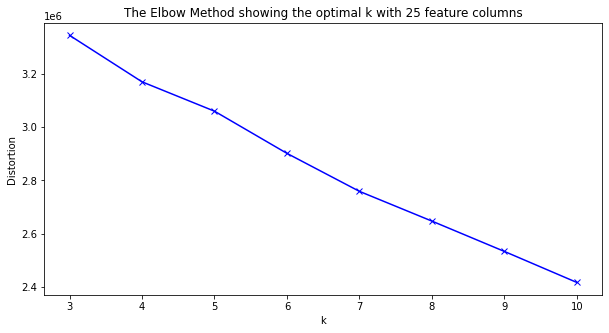

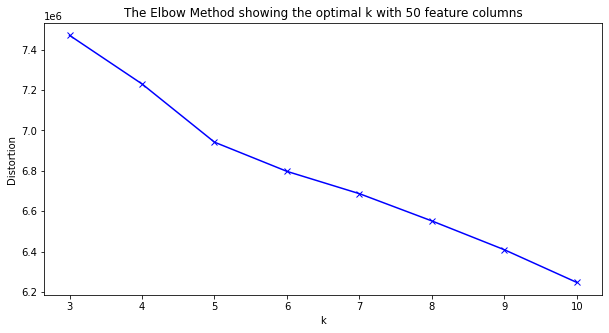

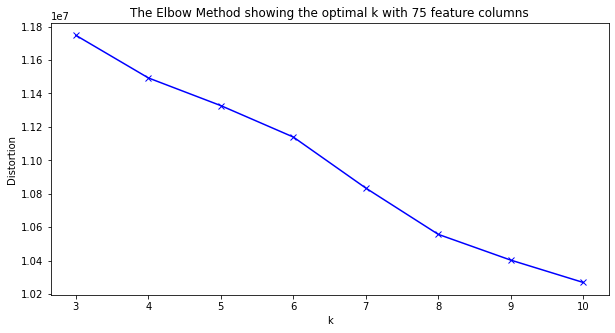

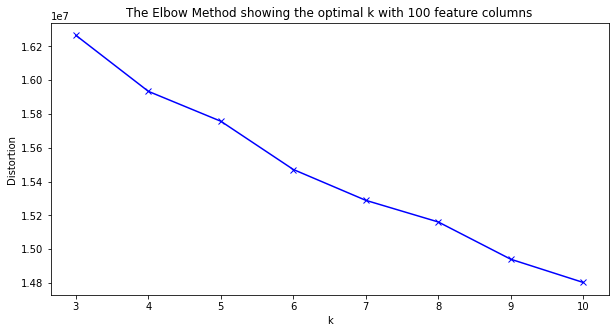

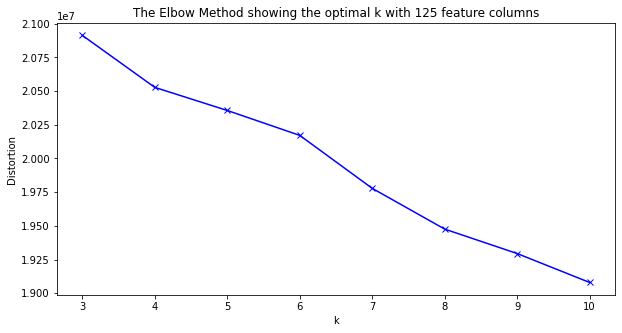

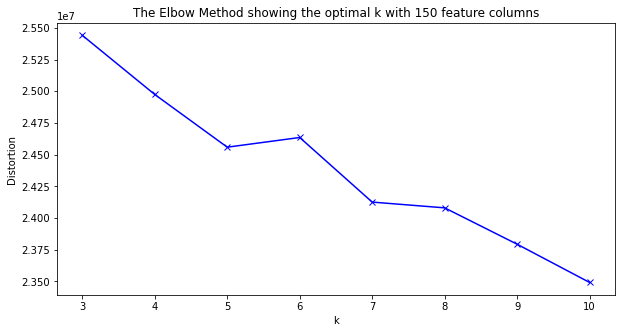

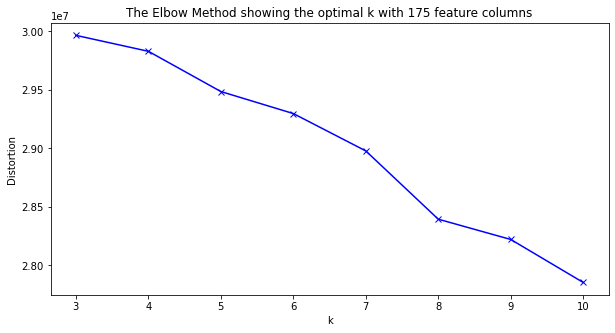

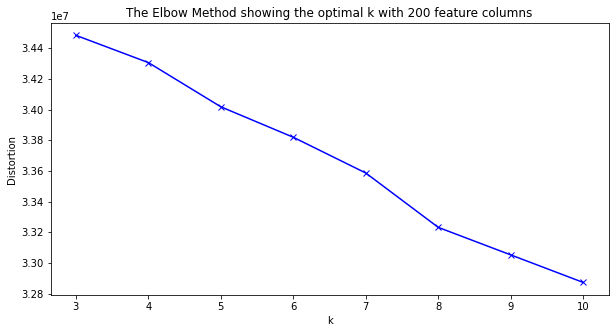

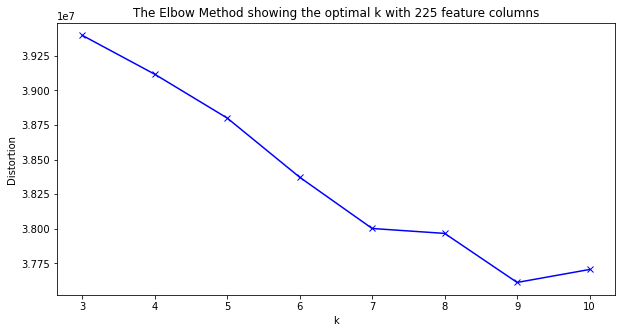

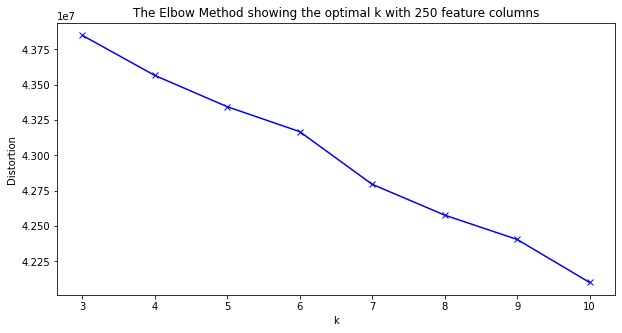

In [18]:
# Identify the optimal number of clusters (k), also considering the number of feature columns. This should assist in review of the cluster samples output.
pd.options.mode.chained_assignment = None  # default='warn'
K = range(3, 11)
for num_of_FT_cols in range(25, 251, 25):
    distortions = []
    for k in K:
        # Create X ensuring only records that have at least one of the features are included
        X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
        X['sum_of_FT_cols'] = X.sum(axis=1)
        X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

        X_scaled = preprocessing.scale(X)

        # Fit and predict model
        kmeans = KMeans(n_clusters=k, random_state=8)
        kmeans.fit(X_scaled)
        distortions.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'The Elbow Method showing the optimal k with {num_of_FT_cols} feature columns')
    plt.show()

In [21]:
# Based on the above diagrams 7 clusters with 225 looks like it could hold some insights
# Create X ensuring only records that have at least one of the features are included
k = 7
X = en_tweets_df_with_features[cols[:225]]
X['sum_of_FT_cols'] = X.sum(axis=1)
X = X[cols[:225]][X['sum_of_FT_cols'] != 0]

# Fit and predict model
kmeans = KMeans(n_clusters=k, random_state=8)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [22]:
# Print a number of tweets for each cluster
y = pd.Series(y_kmeans)
df_tweet_y = pd.DataFrame(en_tweets_df_with_features)
df_tweet_y['y'] = pd.Series(y)

pd.set_option('display.max_colwidth', None)

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------')
print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
print(f'Data shape = {X.shape}')

for i in range(0, k):
    print(f'****************************************** \n Cluster {i}')
    print('******************************************')
    print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i) & (df_tweet_y['is_retweet'] == False)].sample(15).to_string())
    print('****************************************** \n')

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------\n\n\n')

------------------------------------------------------------------------
------------------------------------------------------------------------
k = 7 ---- Number of FT cols = 250
Data shape = (177906, 225)
****************************************** 
 Cluster 0
******************************************
26985                                                                                                                                                                                                                        Real Madrid need a solid goal keeper honestly \n\n#HalaMadrid \n#UCLFinal2018 \n#UCLFinal
19689                                                                                                                                                                               SO CLOSE! Cristiano Ronaldo fires over from a tight angle. Shoot on sight for the Real Madrid. #RMCF #LFC #UCLFinal \n\n⚽🇪🇸🏴󠁧󠁢󠁥󠁮󠁧󠁿
23481    Real Madrid vs Liverpool\n\nFull HD : https://t.co/wda62JrucV \

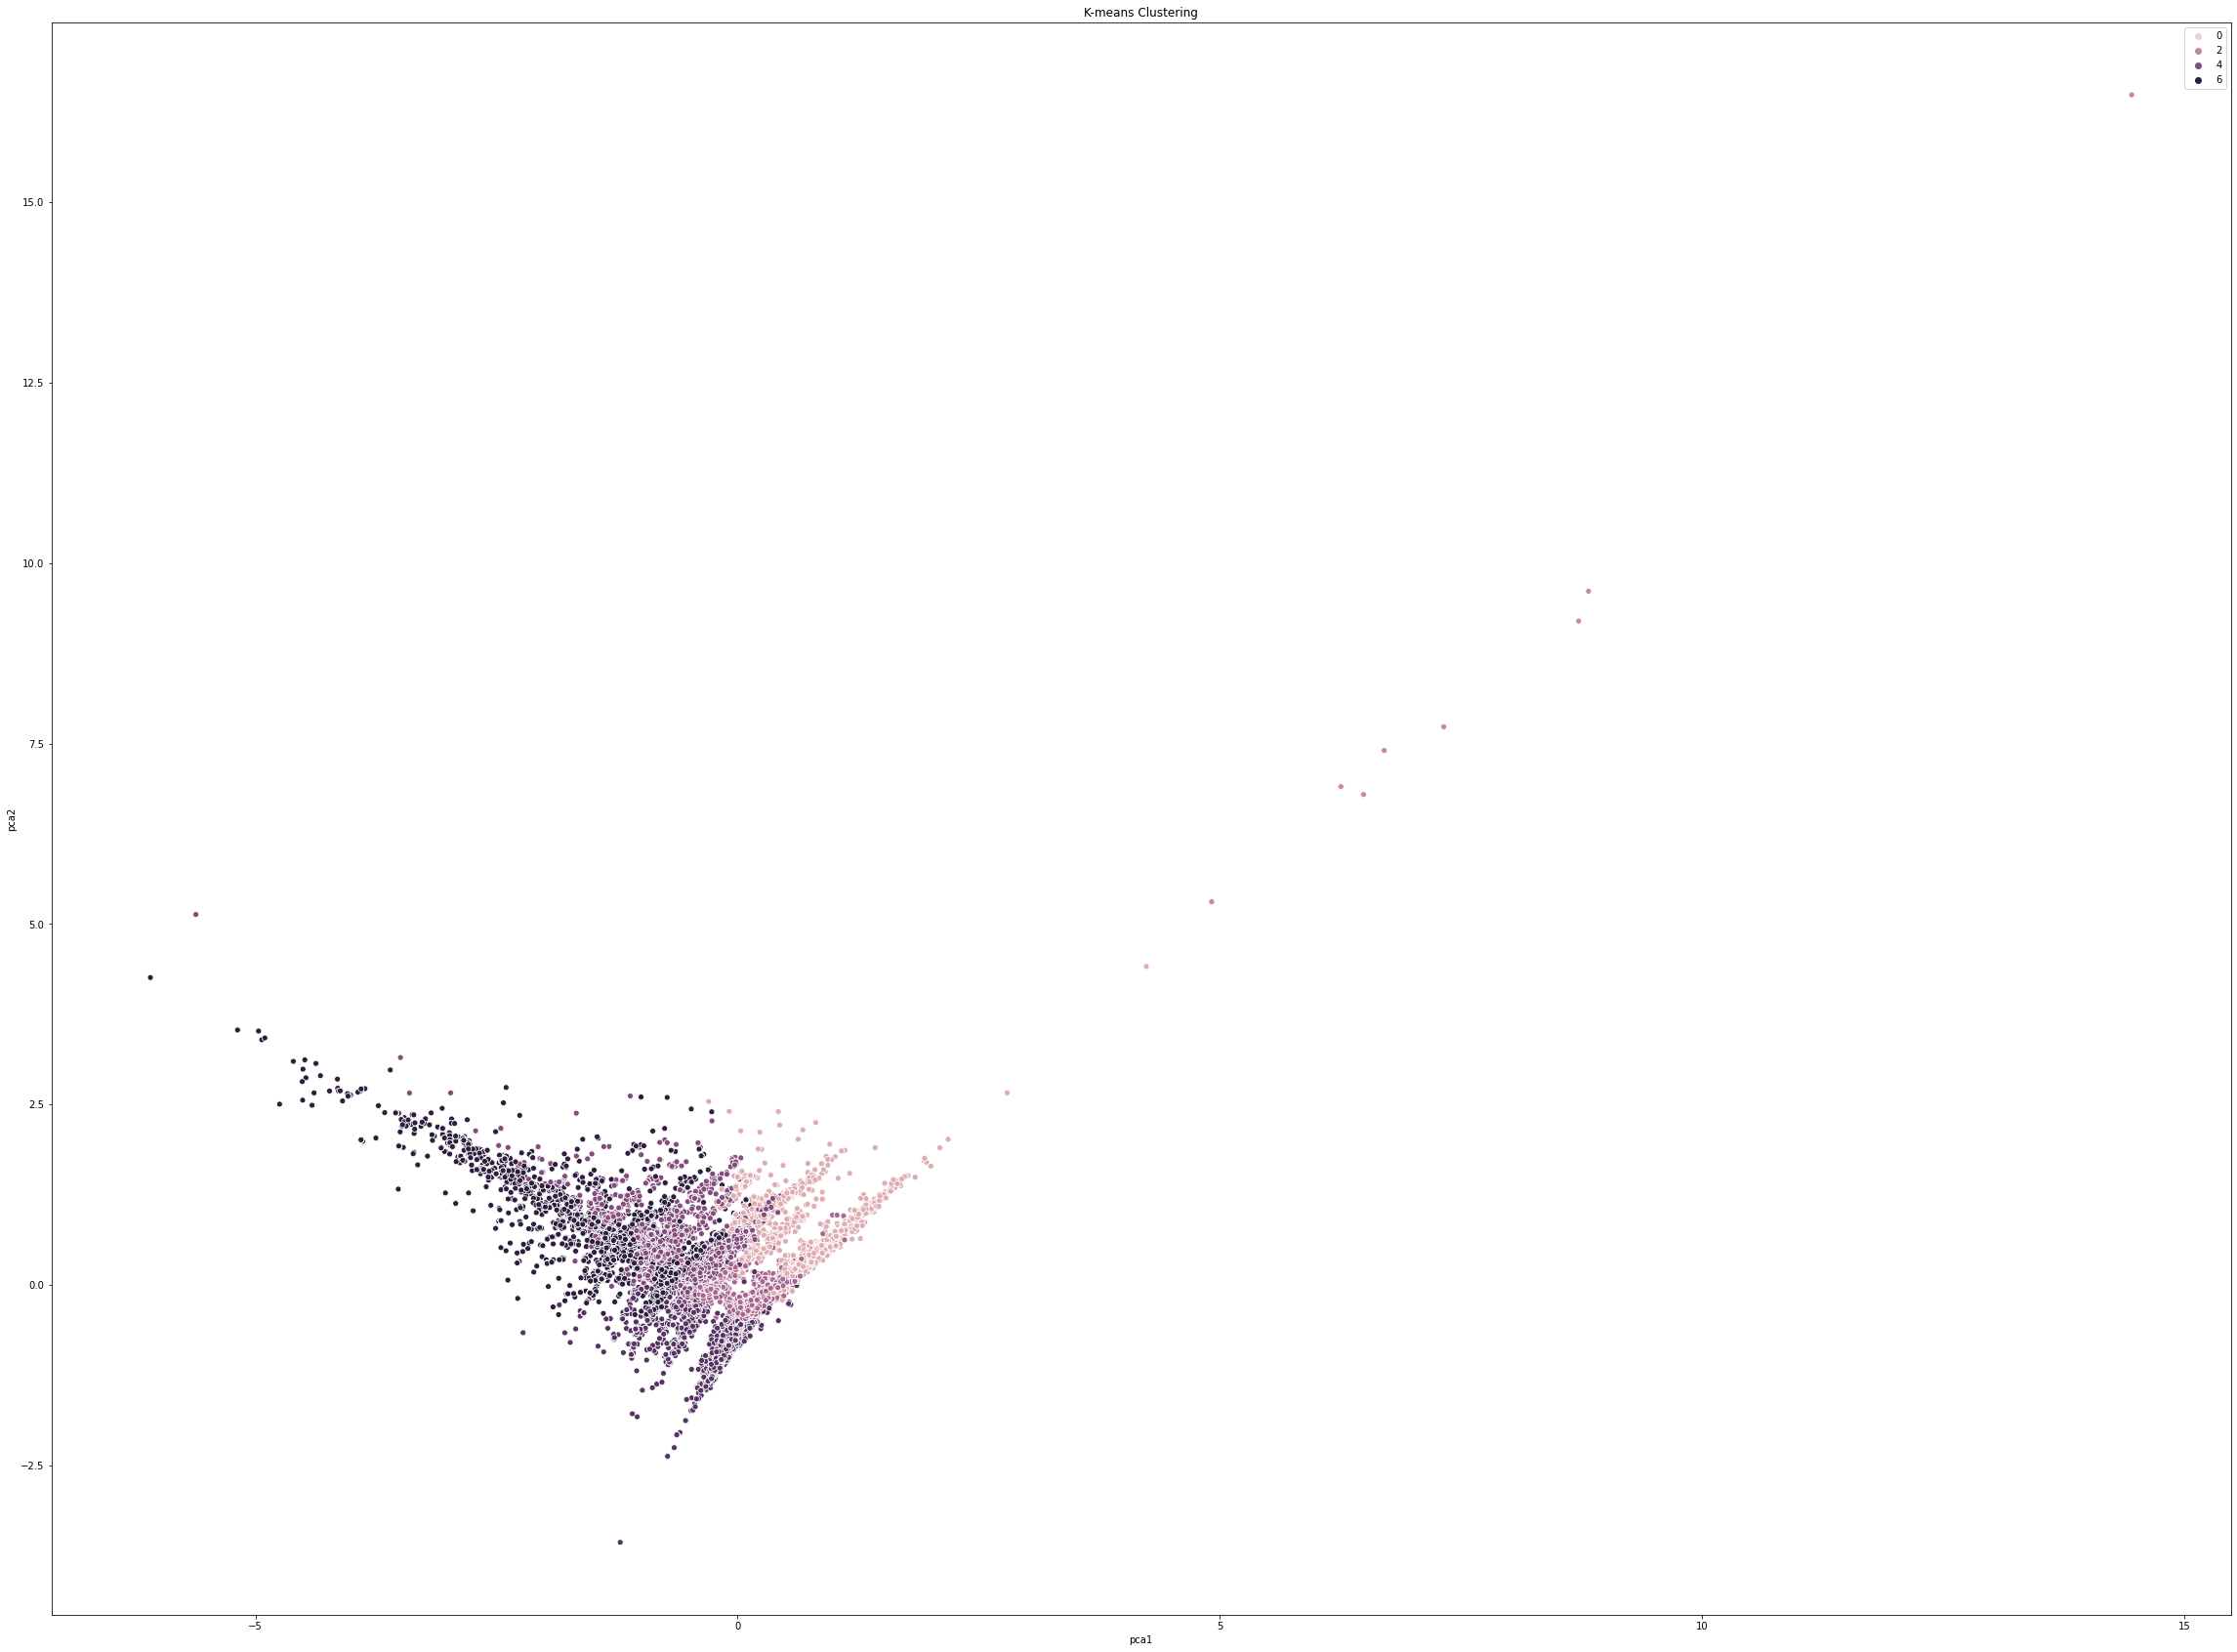

In [23]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

plt.figure(figsize=(40,30))
sns.scatterplot(x="pca1", y="pca2", hue=y_kmeans, data=results)
plt.title('K-means Clustering')
plt.show()

In [ ]:
# Return 3 - 10 clusters for cummulative sets of 25 columns, the first 25 are the most common words
for k in range(3, 11):
    for num_of_FT_cols in range(25, 501, 25):
        # Create X ensuring only records that have at least one of the features are included
        X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
        X['sum_of_FT_cols'] = X.sum(axis=1)
        X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

        # Fit and predict model
        kmeans = KMeans(n_clusters=k, random_state=8)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)
        
        # Print a number of tweets for each cluster
        y = pd.Series(y_kmeans)
        df_tweet_y = pd.DataFrame(en_tweets_df_with_features)
        df_tweet_y['y'] = pd.Series(y)

        pd.set_option('display.max_colwidth', None)
        
        print(f'------------------------------------------------------------------------')
        print(f'------------------------------------------------------------------------')
        print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
        print(f'Data shape = {X.shape}')

        for i in range(0, k):
            print(f'****************************************** \n Cluster {i}')
            print('******************************************')
            print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i) & (df_tweet_y['is_retweet'] == False)].sample(5).to_string())
            print('****************************************** \n')
            
        print(f'------------------------------------------------------------------------')
        print(f'------------------------------------------------------------------------\n\n\n')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# Useful snippets etc.

In [ ]:
###############################################################
# Memory usage https://stackoverflow.com/questions/16261240/releasing-memory-of-huge-numpy-array-in-ipython/16278056
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))